In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.utils import img_to_array, to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
 

In [2]:
# Precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
# Recall metric
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
# F1 score
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

In [19]:
# def add_noise(images):
#     noise_factor = 0.05  # Adjust noise level
#     noise = np.random.randn(*images.shape) * noise_factor
#     noisy_images = images + noise
#     return np.clip(noisy_images, 0., 1.)
 
# # Custom data generator class to inject noise into images
# class NoisyImageDataGenerator(ImageDataGenerator):
#     def flow_from_directory(self, *args, **kwargs):
#         generator = super().flow_from_directory(*args, **kwargs)
#         while True:
#             x_batch, y_batch = next(generator)
#             x_batch = add_noise(x_batch)  # Add noise to images
#             yield x_batch, y_batch
 

In [3]:
DATA_PATH = r'C:\Users\shail\Desktop\NSL\NSL RGB' 

categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")

Categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# load images with their labels and resize images to 224 X 224 pixels.
def load_images_and_labels(data_path, categories, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)  
    return np.array(images, dtype=np.float16), np.array(labels)

images, labels = load_images_and_labels(DATA_PATH, categories)

In [7]:
# encode the labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)


one_hot_labels = to_categorical(integer_encoded)


print("One-Hot Encoding Output:")
print(f"Original Label: {labels[0]} - Encoded: {one_hot_labels[0]}")
print(f"Original Label: {labels[-1]} - Encoded: {one_hot_labels[-1]}")

One-Hot Encoding Output:
Original Label: 0 - Encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original Label: 9 - Encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [8]:
# Split the dataset
X_train, X_test, y_labels, y_test_labels = train_test_split(
    images, 
    one_hot_labels, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True, 
    stratify=one_hot_labels
)

In [5]:
from tensorflow.keras.applications.resnet import preprocess_input

In [21]:
from tensorflow.keras.applications.resnet import ResNet50


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
predictions = Dense(10, activation='softmax')(x)
 

model = Model(inputs=base_model.input, outputs=predictions)
 


 
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# preprocess the images for finetuning VGG16 pretrained
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [22]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

initial_learning_rate = 0.001

optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.2,            
    patience=5,           
    min_lr=1e-6            
)


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    verbose=1,
    mode=max,
    restore_best_weights=True
)


C:\Users\shail\AppData\Local\Temp\ipykernel_15972\3229762160.py:18: UserWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  early_stopping = EarlyStopping(


In [24]:
history = model.fit(
    X_train, y_labels,
    validation_data=(X_test, y_test_labels),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 685s 4s/step - accuracy: 0.3455 - loss: 1.9779 - val_accuracy: 0.6014 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 686s 4s/step - accuracy: 0.6658 - loss: 0.9313 - val_accuracy: 0.7164 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.7673 - loss: 0.6585 - val_accuracy: 0.7902 - val_loss: 0.6175 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 669s 4s/step - accuracy: 0.8256 - loss: 0.5221 - val_accuracy: 0.7428 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 667s 4s/step - accuracy: 0.8436 - loss: 0.4549 - val_accuracy: 0.7766 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 664s 4s/step - accuracy: 0.8696 - loss: 0.3950 - val_accuracy: 0.8277 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 672s 4s/step - accuracy: 0.8917 - loss: 0.

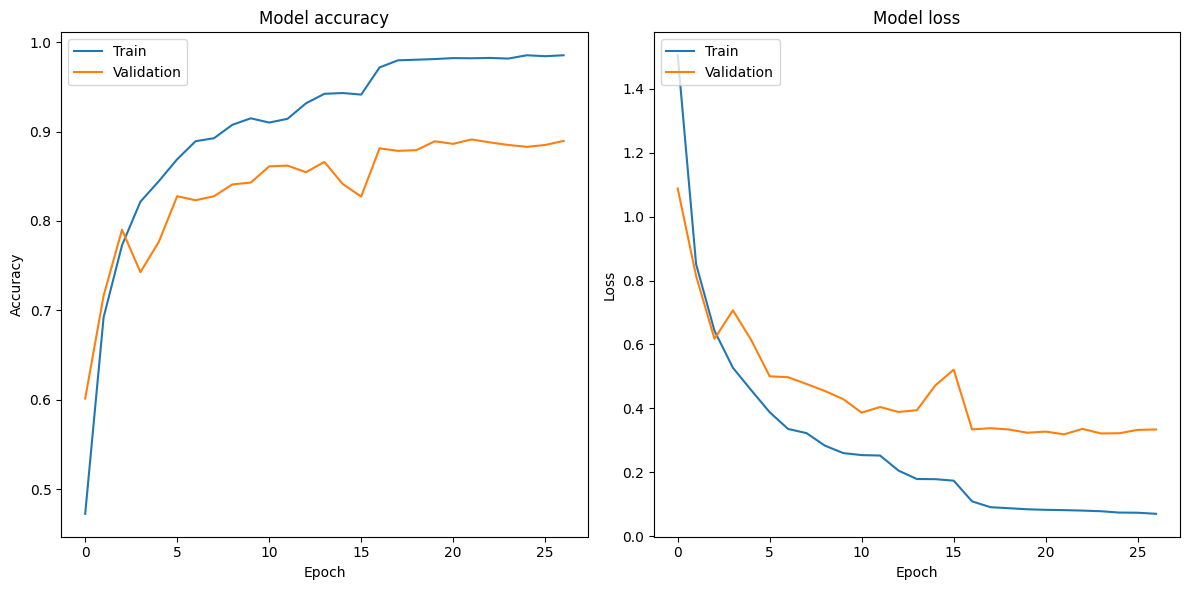

In [25]:
# plotting the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()

In [33]:
model.save('_pretrained_resnet50.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


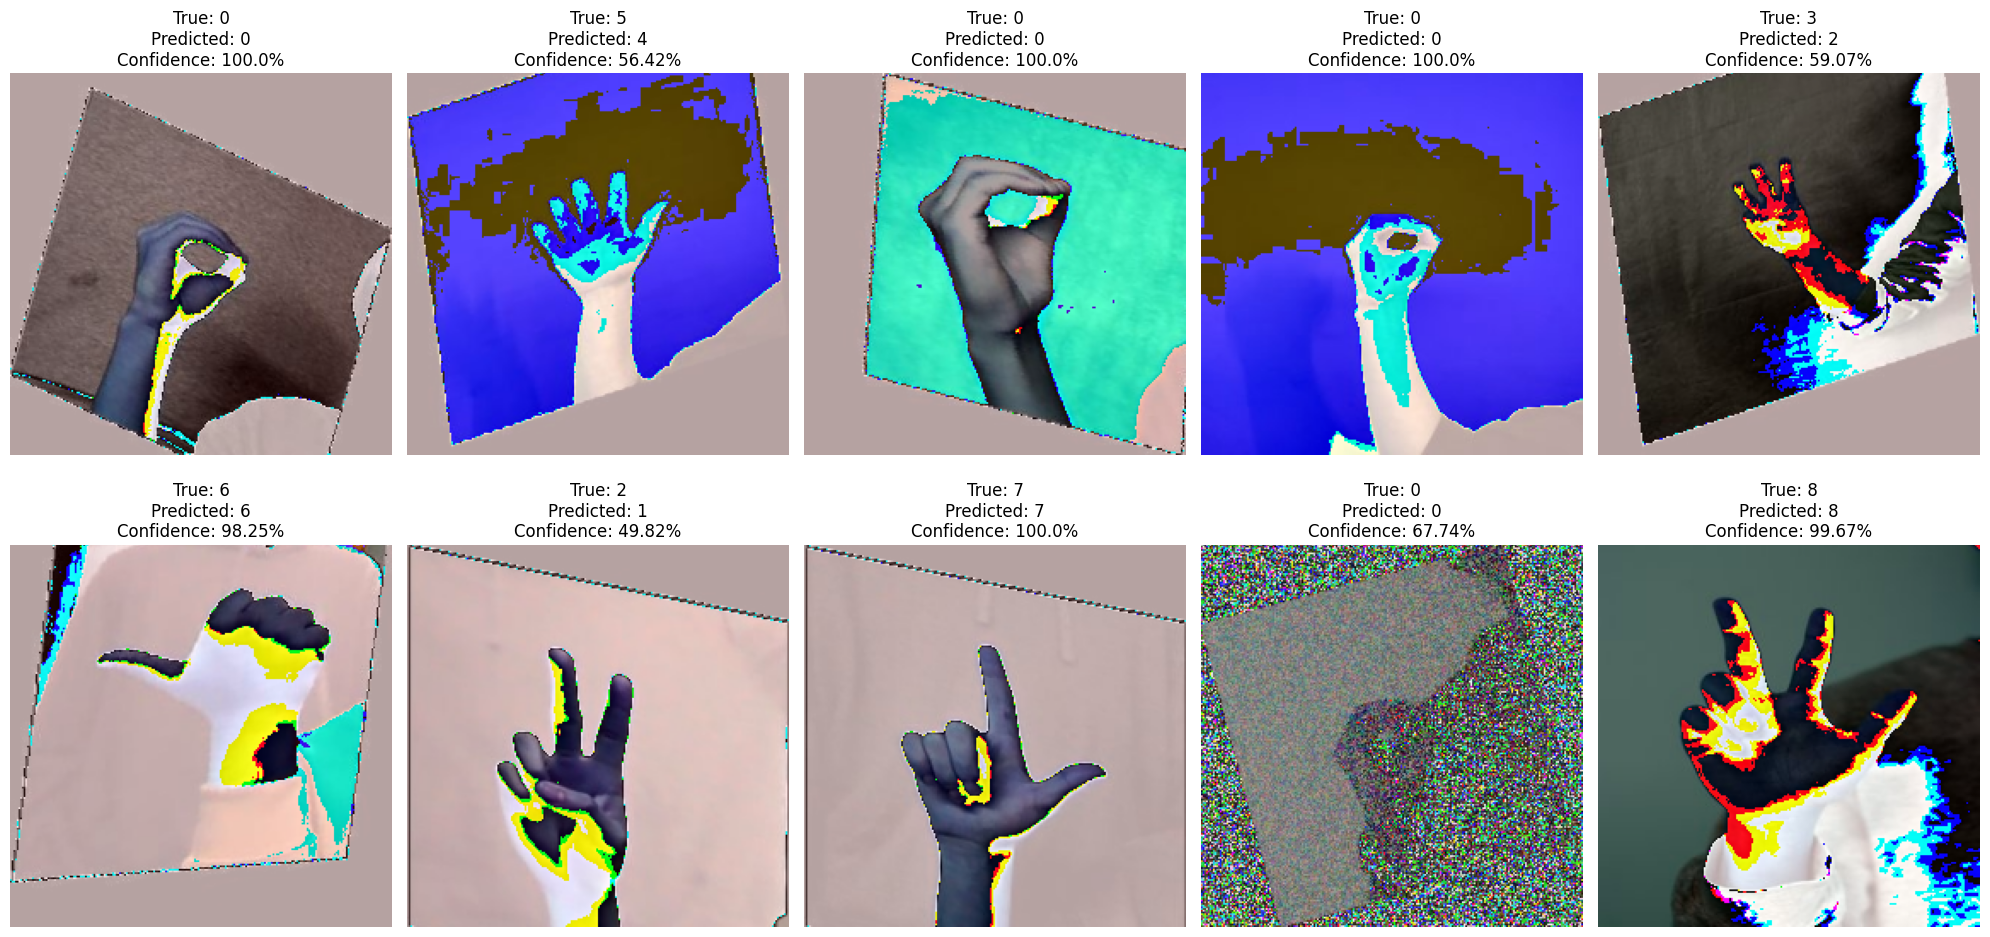

In [29]:

def display_predictions(model, X_test, y_test_labels, class_names, num_images=10):

    random_indices = np.random.choice(len(X_test), size=num_images, replace=False)

    
    plt.figure(figsize=(20, 10))  

    for i, index in enumerate(random_indices):
     
        image = X_test[index]
        true_label = y_test_labels[index]

      
        img_array = np.expand_dims(image, axis=0) 
        predictions = model.predict(img_array)

   
        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * np.max(predictions[0]), 2)

   
        plt.subplot(2, 5, i + 1) 
        plt.axis('off')
        plt.imshow(image.astype('uint8')) 
        plt.title(f"True: {class_names[np.argmax(true_label)]}\nPredicted: {predicted_class}\nConfidence: {confidence}%")

    plt.tight_layout()  
    plt.show()


display_predictions(model, X_test, y_test_labels, label_encoder.classes_, num_images=10)
 

In [30]:
model = load_model('_pretrained_resnet50.keras')

y_pred = model.predict(X_test) 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_test_labels, axis=1)  

76/76 ━━━━━━━━━━━━━━━━━━━━ 953s 13s/step


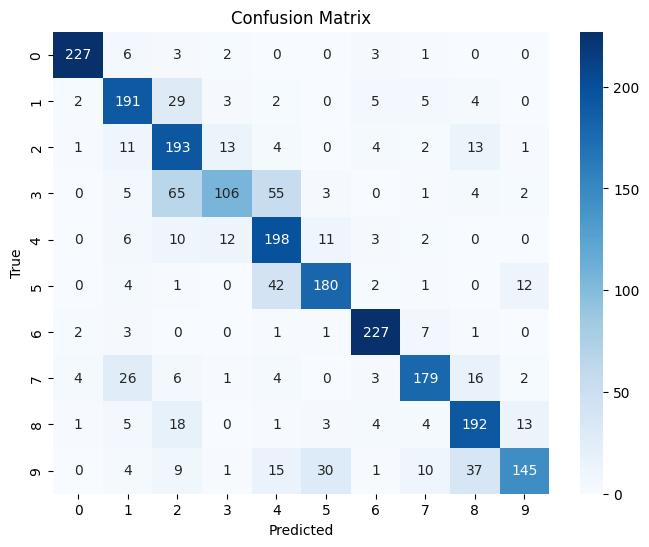

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       242
           1       0.73      0.79      0.76       241
           2       0.58      0.80      0.67       242
           3       0.77      0.44      0.56       241
           4       0.61      0.82      0.70       242
           5       0.79      0.74      0.77       242
           6       0.90      0.94      0.92       242
           7       0.84      0.74      0.79       241
           8       0.72      0.80      0.76       241
           9       0.83      0.58      0.68       252

    accuracy                           0.76      2426
   macro avg       0.77      0.76      0.76      2426
weighted avg       0.77      0.76      0.75      2426



In [32]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
 
# Classification Report
labels = list(range(10))  
print(classification_report(y_true_classes, y_pred_classes, target_names=[str(label) for label in labels]))

In [13]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

model = load_model('_pretrained_vgg16.keras')

# Define the label names corresponding to the hand signs (0 to 9 in Nepali)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


def preprocess_image(image):
 
    image = cv2.resize(image, (224, 224))
   
    image = np.array(image, dtype='float32')
    image = preprocess_input(image)
    
    # Expand dimensions to match the model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)  
    return image


def display_result(roi, predicted_label):

    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    plt.imshow(roi_rgb)
    plt.title(f'Prediction: {predicted_label}')
    plt.axis('off')  # Hide axes
    plt.show()


cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    # Resize the frame to make it larger (e.g., 1.5 times the original size)
    frame = cv2.resize(frame, (int(frame.shape[1] * 1.5), int(frame.shape[0] * 1.5)))

    
    x, y, w, h = 80, 150, 350, 350  # Adjust ROI position and size as needed
    roi = frame[y:y+h, x:x+w]


    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)


    cv2.imshow("Frame", frame)

    # If 'c' is pressed, capture the ROI and make a prediction
    key = cv2.waitKey(1)
    if key == ord('c'):
       
        processed_image = preprocess_image(roi)
    
        prediction = model.predict(processed_image)
        

        predicted_class = np.argmax(prediction[0]) 
        confidence = np.max(prediction[0])  
        predicted_label = labels[predicted_class]
        
        # Debug: Print the predicted class, label, and confidence
        print(f"Predicted class index: {predicted_class}, Confidence: {confidence:.2f}")

        
        cv2.putText(frame, f'Prediction: {predicted_label}, Confidence: {confidence:.2f}', 
                    (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        
        cv2.imshow("Frame", frame)

      
        display_result(roi, predicted_label)

    # If 'q' is pressed, exit the loop
    if key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()
